# AutoML and Timeseries Meetup - Hands On

https://github.com/NeuralAlgorithms/firefly-tutorials/tree/master/meetup_automl_timeseries


## Setup

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.base import BaseEstimator, RegressorMixin

## Example Time Series Data Set

Average time step: 31 days 00:00:00


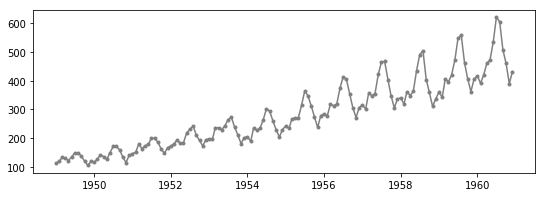

In [2]:
data = pd.read_csv('data/air_passengers.csv', parse_dates=['date'])
plt.figure(figsize=(9,3))
plt.plot(data.date, data.y, '.-', c='gray')

t_diff_median = data.date.diff().median()
print('Average time step: {!s}'.format(t_diff_median))

## Fitting a Model

In [3]:
def fit_model(t, X, y, distance, test_size=0.2, log_transform=False, estimator=None, plot=False):
    
    # apply forecast distance
    X = X.shift(distance)
    
    # ignore missing value rows
    non_null = X.dropna(how='any').index.values

    # create holdout set
    if isinstance(test_size, float):
        test_size = int(test_size * len(t))
    train = non_null[:-test_size]
    test  = non_null[-test_size:]

    # standardize
    numeric_cols = X.select_dtypes(include=[np.number]).columns
    centers = X.loc[train, numeric_cols].mean(axis=0)
    scales = np.maximum(1e-15, X.loc[train, numeric_cols].std(axis=0))
    X[numeric_cols] = (X[numeric_cols] - centers)/scales
    
    # fit model
    if estimator is None:
        estimator = ElasticNetCV(n_alphas=100, l1_ratio=0.9, cv=5, random_state=123)
    if log_transform:
        estimator = MultiplicativeEstimator(estimator)
    estimator.fit(X.loc[train, :], y[train])
    test_score = estimator.score(X.loc[test, :], y[test])

    # plot the fit
    if plot:
        plt.figure(figsize=(9,3))
        plt.plot(t, y, '.', c='gray', alpha=0.7)
        plt.plot(t[train], estimator.predict(X.loc[train, :]), 'b-', lw=2, alpha=0.7)
        plt.plot(t[test], estimator.predict(X.loc[test, :]),  'r-', lw=2, alpha=0.7)
        plt.annotate('Test Score: {}'.format(test_score), 
                     xy=(0, 1), xytext=(12, -12), va='top', 
                     xycoords='axes fraction', textcoords='offset points')
        plt.show()
    return estimator, test_score


def feature_importance_summary(model):
    if hasattr(model, 'coef_'):
        coef = pd.Series(model.coef_, index=X.columns, name='Importance')
        importances = coef.abs()
        importances.sort_values(ascending=False, inplace=True)
        importances = importances[importances > 1e-15]
        display(importances.to_frame().style.bar())
    else:
        raise NotImplemented('Only linear models supported at the momemnt.')
        

class MultiplicativeEstimator(BaseEstimator, RegressorMixin):
    
    def __init__(self, estimator):
        self.estimator = estimator
        
    def fit(self, X, y, *args, **kwargs):
        self.estimator.fit(X, np.log(y), *args, **kwargs)
        return self
    
    def predict(self, X):
        return np.exp(self.estimator.predict(X))
    
    def __getattr__(self, name):
        return getattr(self.estimator, name)

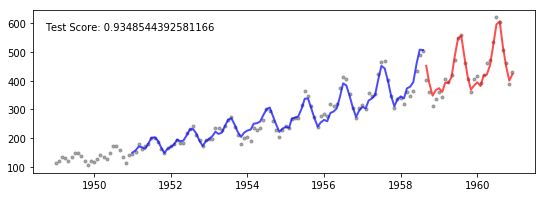

,Importance
lag 0,37.5104
lag 12,26.9771
lag 1,14.2074
lag 11,9.16934
lag 8,4.59176
lag 9,1.61383
lag 7,1.42962
lag 2,0.958577
lag 3,0.40394


In [4]:
# read the data
data = pd.read_csv('data/air_passengers.csv', parse_dates=['date'])
t = data['date']
y = data['y']

# create features in new dataframe
X = pd.DataFrame()
X['lag 0'] = y.shift(0)
X['lag 1'] = y.shift(1)
X['lag 2'] = y.shift(2)
X['lag 3'] = y.shift(3)
X['lag 4'] = y.shift(4)
X['lag 5'] = y.shift(5)
X['lag 6'] = y.shift(6)
X['lag 7'] = y.shift(7)
X['lag 8'] = y.shift(8)
X['lag 9'] = y.shift(9)
X['lag 10'] = y.shift(10)
X['lag 11'] = y.shift(11)
X['lag 12'] = y.shift(12)

# fit
model, score = fit_model(t, X, y, plot=True, distance=12)

# display importances
feature_importance_summary(model)

## Number of Lags

Text(0, 0.5, 'Test Score')

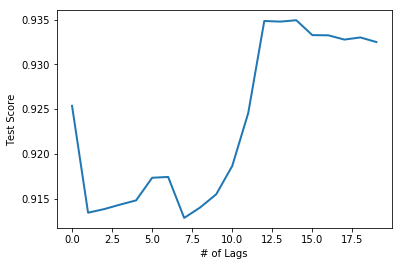

In [ ]:
# read the data
data = pd.read_csv('data/air_passengers.csv', parse_dates=['date'])
t = data['date']
y = data['y']
X = pd.DataFrame()

lag_counts = range(0, 20)
scores = []

for i in lag_counts:
    X['lag {}'.format(i)] = y.shift(i)
    model, score = fit_model(t, X, y, distance=12)
    scores.append(score)
    
plt.figure()
plt.plot(lag_counts, scores, lw=2)
plt.xlabel('# of Lags')
plt.ylabel('Test Score')


## More Types of Features

/home/noam/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


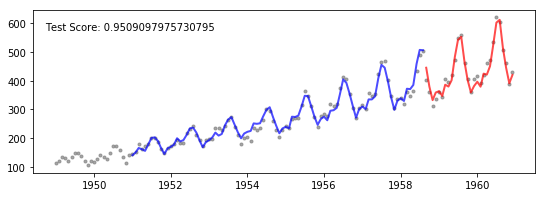

,Importance
lag 0,45.918
t,28.0498
lag 12,23.0298
rolling min 12,16.1501
lag 11,7.70923
rolling mean 3,5.10292
lag 2,4.84383
lag 1,4.30631
rolling max 12,4.28897
lag 7,4.28684


In [ ]:
# read the data
data = pd.read_csv('data/air_passengers.csv', parse_dates=['date'])
t = data['date']
y = data['y']

# create features in new dataframe
X = pd.DataFrame()
X['lag 0'] = y.shift(0)
X['lag 1'] = y.shift(1)
X['lag 2'] = y.shift(2)
X['lag 3'] = y.shift(3)
X['lag 4'] = y.shift(4)
X['lag 5'] = y.shift(5)
X['lag 6'] = y.shift(6)
X['lag 7'] = y.shift(7)
X['lag 8'] = y.shift(8)
X['lag 9'] = y.shift(9)
X['lag 10'] = y.shift(10)
X['lag 11'] = y.shift(11)
X['lag 12'] = y.shift(12)
X['t'] = (t - t.min())/(t.max() - t.min())
X['rolling mean 3'] = y.rolling(3).mean()
X['rolling mean 6'] = y.rolling(6).mean()
X['rolling mean 12'] = y.rolling(12).mean()
X['rolling std 12'] = y.rolling(12).std()
X['rolling min 12'] = y.rolling(12).min()
X['rolling max 12'] = y.rolling(12).max()
X['rolling median 12'] = y.rolling(12).median()

model, score = fit_model(t, X, y, plot=True, distance=12)

feature_importance_summary(model)

# Time Learning Curve

In [ ]:
row_counts = range(X.shape[0] // 2, X.shape[0] + 1)
scores = []

for n in row_counts:
    recent = X.index[-n:]
    model, score = fit_model(t.loc[recent], X.loc[recent, :], y.loc[recent], distance=12)
    scores.append(score)

plt.figure()
plt.plot(100.0*np.array(row_counts)/X.shape[0], scores, lw=2)
plt.axhline(max(scores), linestyle='--', color='gray')
plt.xlabel('% recent rows')
plt.ylabel('Test Score')

plt.figure(figsize=(9,3))
plt.plot(t, y, '-', lw=2)
plt.axvline(t.iloc[-np.argmax(row_counts)], linestyle='--', color='gray')

/home/noam/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/noam/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/noam/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/noam/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might wa

## Forecast Distance

In [ ]:
distances = range(0, 36)
scores = []

for i in distances:
    model, score = fit_model(t, X, y, distance=i)
    scores.append(score)

plt.figure()
plt.plot(distances, scores, lw=2)
plt.xlabel('Forecast Distance')
plt.ylabel('Test Score')

## Log Transform / Differencing

In [ ]:
# read the data
data = pd.read_csv('data/air_passengers.csv', parse_dates=['date'])
t = data['date']
y = data['y']

# normal
plt.figure(figsize=(9,3))
plt.plot(t, y)
plt.ylabel('Normal')

# differencing
plt.figure(figsize=(9,3))
plt.plot(t, y - y.shift(12), 'r')
plt.ylabel('12 Month Differenced')

# log transform
log_y = y.apply(np.log)
plt.figure(figsize=(9,3))
plt.plot(t, log_y, 'g');
plt.ylabel('Log Transformed')

# both
plt.figure(figsize=(9,3))
plt.plot(t, log_y - log_y.shift(12), 'm')
plt.ylabel('Differenced and Log Transformed')
